In [1]:
# Imports
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
# Four rooms environment class copied and pasted from my ex0 submission
class Environment:
    
    def __init__(self, rows, cols, walls):
        
        self.rows = rows
        self.cols = cols
        self.walls = walls
        self.x = 0
        self.y = 0
        self.x_prev = 0
        self.y_prev = 0
        self.bank = 0
        
    def draw(self):
        for row in range(self.rows):
            for col in range(self.cols):
                if ((self.rows-row-1, col)) in self.walls:
                    print("{}   ".format("1"), end="")
                elif ((self.rows-row-1, col)) == (self.rows-1, self.cols-1):
                    print("{}   ".format("F"), end="")
                elif ((self.rows-row-1, col)) == (self.x, self.y):
                    print("{}   ".format("P"), end="")
                else:
                    print("{}   ".format("0"), end="")
            print("\n")
                        
    def step(self, action):
        slips = np.random.choice([True, False], p=[0.2, 0.8])
        self.x_prev=self.x
        self.y_prev=self.y
        if action == "LEFT":
            if slips:
                self.x=self.x+np.random.choice([1, -1], p=[0.5, 0.5])
            else:
                self.y=self.y-1
            self.correct()
            return self.reward()
        elif action == "RIGHT":
            if slips:
                self.x=self.x+np.random.choice([1, -1], p=[0.5, 0.5])
            else:
                self.y=self.y+1
            self.correct()
            return self.reward()
        elif action == "UP":
            if slips:
                self.y=self.y+np.random.choice([1, -1], p=[0.5, 0.5])
            else:
                self.x=self.x+1
            self.correct()
            return self.reward()
        elif action == "DOWN":
            if slips:
                self.y=self.y+np.random.choice([1, -1], p=[0.5, 0.5])
            else:
                self.x=self.x-1
            self.correct()
            return self.reward()
        
    def reward(self):
        if ((self.rows-self.x-1, self.y)) == (self.rows-1, self.cols-1):
            self.bank+=1
            self.restart()
            return (1, True)
        else:
            return (0, False)
        
    def correct(self):
        if self.x<0:
            self.x=self.x_prev
        elif self.x==self.rows:
            self.x=self.x_prev
        elif self.y<0:
            self.y=self.y_prev
        elif self.y==self.cols:
            self.y=self.y_prev
        elif ((self.x, self.y)) in self.walls:
            self.x=self.x_prev
            self.y=self.y_prev
            
    def restart(self):
        self.x = 0
        self.y = 0
        self.x_prev = 0
        self.y_prev = 0
        
    def reset(self):
        self.restart()
        self.bank = 0
        
    def loc(self):
        return (self.x, self.y)

In [3]:
# Function to initialize policy, qfunction, and return dictionaries
def initialize():
    policy = {}
    for row in range(ROWS):
        for col in range(COLS):
            policy[row,col] = np.random.choice(action_space)

    qfunction = {}
    returns = {}
    for row in range(ROWS):
        for col in range(COLS):
            for action in action_space:
                qfunction[(row, col), (action)] = np.random.rand()
                returns[(row, col), (action)] = []
                
    return policy, qfunction, returns

In [4]:
# Function to generate an episode following policy
def play(policy, qfunction, returns, gamma):
    environment.reset()
    moves = 0
    episode = []
    while True:
        state = environment.loc()
        action = policy[environment.loc()]
        reward, done  = environment.step(policy[environment.loc()])
        episode.append(tuple((state, action, reward)))
        moves +=1
        if moves > 459 or done:
            break
    return (episode, 1*gamma**len(episode))

In [5]:
# Hyperparameters
action_space = ["UP", "DOWN", "LEFT", "RIGHT"]
ROWS = 11
COLS = 11
WALLS = [
    (5, 0),
    (5, 2),
    (5, 3),
    (5, 4),
    (5, 5),
    (4, 5),
    (4, 6),
    (4, 7),
    (4, 9),
    (4, 10),
    (0, 5),
    (2, 5),
    (3, 5),
    (6, 5),
    (7, 5),
    (9, 5),
    (10, 5),
]
environment = Environment(rows=ROWS, cols=COLS, walls=WALLS)

In [6]:
def run_trials(trials, epochs, epsilon, gamma):
    data = []
    for trial in tqdm(range(trials)):

        policy, qfunction, returns = initialize()
        rewards = []

        for epoch in range(epochs):

            episode, reward = play(policy, qfunction, returns, gamma)
            rewards.append(reward)
            G = 0

            for T, step in enumerate(reversed(episode)):
                state, action, reward = step
                G = gamma * G + int(reward)
                if [state, action] not in [[step[0], step[1]] for step in episode[:-T-1]]:
                    returns[state, action].append(G)
                    qfunction[state, action] = np.average(returns[state, action])
                    argmax = max(action_space, key= lambda a: qfunction[state, a])
                    policy[state] = np.random.choice([argmax, np.random.choice(action_space)], p=[1-epsilon, epsilon])

        data.append(rewards)

    return np.array(data)

100%|██████████| 10/10 [03:15<00:00, 19.51s/it]


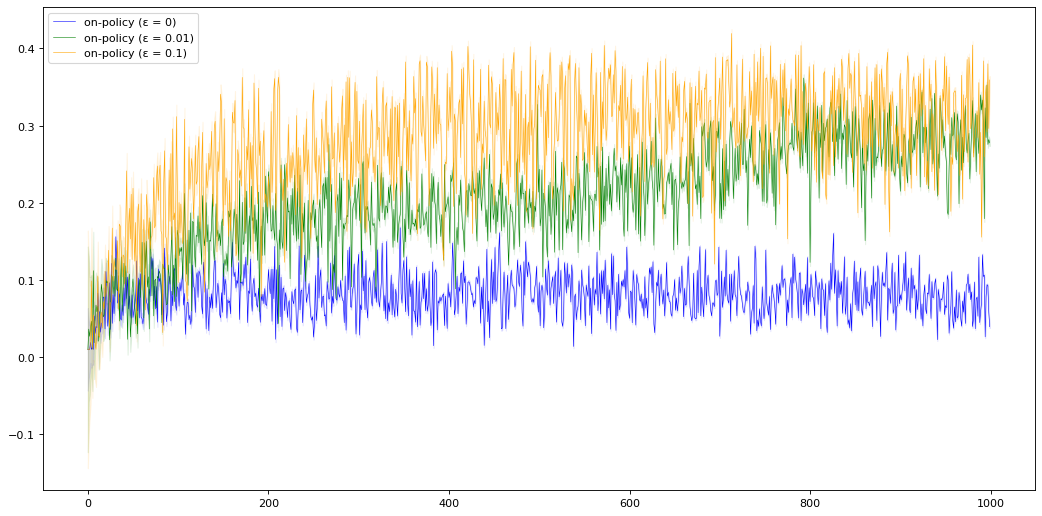

In [7]:
# Plotting code
plt.figure(figsize=(16, 8), dpi=80)

data = run_trials(10, 1000, 0, 0.99)
rew_err = 1.96 * (np.std(np.mean(data, axis=0), axis=0) / np.sqrt(range(1,1001)))
plt.plot(np.mean(data, axis=0), color='blue', linewidth=0.5, label="on-policy (ε = 0)")
plt.fill_between(range(1000), np.mean(data, axis=0) - rew_err, np.mean(data, axis=0) + rew_err, alpha=0.1, color='blue')

data = run_trials(10, 1000, 0.01, 0.99)
rew_err = 1.96 * (np.std(np.mean(data, axis=0), axis=0) / np.sqrt(range(1,1001)))
plt.plot(np.mean(data, axis=0), color='green', linewidth=0.5, label="on-policy (ε = 0.01)")
plt.fill_between(range(1000), np.mean(data, axis=0) - rew_err, np.mean(data, axis=0) + rew_err, alpha=0.1, color='green')

data = run_trials(10, 1000, 0.1, 0.99)
rew_err = 1.96 * (np.std(np.mean(data, axis=0), axis=0) / np.sqrt(range(1,1001)))
plt.plot(np.mean(data, axis=0), color='orange', linewidth=0.5, label="on-policy (ε = 0.1)")
plt.fill_between(range(1000), np.mean(data, axis=0) - rew_err, np.mean(data, axis=0) + rew_err, alpha=0.1, color='orange')

plt.legend()
plt.show()

In [8]:
# Plot qfunction of policy
prime = dict(item for item in qfunction.items() if policy[item[0][0]] == item[0][1])
for wall in WALLS:
    prime[wall, policy[wall]] = 0
plt.imshow(np.array(list(prime.values())).reshape(ROWS, COLS))
plt.axis('off')
plt.colorbar()

NameError: name 'qfunction' is not defined